# Preprocesamiento de Datos Meteorológicos - Reportes METAR

## Objetivo
Este notebook tiene como objetivo realizar el preprocesamiento y preparación de los datos meteorológicos crudos para el análisis, incluyendo:
- Limpieza y validación de datos
- Eliminación de registros inválidos
- Extracción de características meteorológicas relevantes
- Normalización y transformación de datos
- Preparación del dataset procesado para modelos de predicción

**Nota:** El análisis exploratorio (EDA) se encuentra en `01_exploracion.ipynb`

---

## 1. Importe de librerías

In [34]:
# Importación de librerías necesarias para el análisis y preprocesamiento
import pandas as pd  # Para manipulación de datos
import numpy as np   # Para operaciones numéricas
import matplotlib.pyplot as plt  # Para visualizaciones
import seaborn as sns  # Para visualizaciones estadísticas avanzadas
import re  # Para expresiones regulares (parsing de texto METAR)

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Librerías importadas correctamente")

Librerías importadas correctamente


In [ ]:
# Carga de datos crudos desde el archivo CSV
# Estos datos contienen reportes meteorológicos en formato METAR (Meteorological Aerodrome Report)
df_raw = pd.read_csv('../../data/raw/DATOS_CRUDOS.csv')

print(f"Datos cargados correctamente")
print(f"Forma inicial del dataset: {df_raw.shape[0]} filas x {df_raw.shape[1]} columnas")

Datos cargados correctamente
Forma inicial del dataset: 157635 filas x 9 columnas


,ID_ESTACION,FECHA_REPORTE,HORA_REPORTE,TIPO_REPORTE,TEXTO_REPORTE,FECHA_INGRESO,CEDULA,FECHA_HORA_INSERCION,BANDERA
0,392,1900-01-01 23:59:59.000,1900-01-01 23:59:59.000,METAR,SKBQ NIL,2007-05-31 11:39:29.000,NaN,NaN,L
1,392,2006-07-20 00:00:00.000,2006-07-20 00:00:00.000,METAR,SKBQ 200000Z 03009KT 9999 TS FEW015CB SCT080 28/24 A2983 CB/TS S,2006-07-19 19:22:25.000,NaN,NaN,A
2,392,2006-07-20 01:00:00.000,2006-07-20 01:00:00.000,METAR,SKBQ 200100Z 25008KT 9999 TS FEW015CB SCT080 27/23 A2985,2006-07-19 20:25:49.000,NaN,NaN,A
3,392,2006-07-20 06:00:00.000,2006-07-20 06:00:00.000,METAR,SKBQ 200600Z 29006KT 9999 FEW015 SCT080 26/23 A2985,2006-07-20 01:24:29.000,NaN,NaN,A
4,392,2006-07-20 07:00:00.000,2006-07-20 07:00:00.000,METAR,SKBQ 200700Z 32006KT 9999 SCT012 26/24 A2984,2006-07-20 02:26:52.000,NaN,NaN,A


---

## 2. Limpieza y Preparación de Datos

### 2.1 Eliminación de registros inválidos

Los reportes METAR pueden contener valores "NIL" que indican datos no disponibles o inválidos. Estos deben eliminarse antes del preprocesamiento.


In [ ]:
# Eliminar registros inválidos que contienen "NIL"
print("=" * 60)
print("ELIMINACIÓN DE REGISTROS INVÁLIDOS")
print("=" * 60)

registros_iniciales = len(df_raw)
invalid_count = df_raw["TEXTO_REPORTE"].str.contains("NIL", na=False).sum()
invalid_percent = (invalid_count / registros_iniciales) * 100

print(f"\n Registros iniciales: {registros_iniciales:,}")
print(f" Registros inválidos (NIL): {invalid_count:,} ({invalid_percent:.2f}%)")

# Eliminar registros inválidos
df_raw = df_raw[~df_raw["TEXTO_REPORTE"].str.contains("NIL", na=False)].copy()

registros_validos = len(df_raw)
print(f" Registros válidos después de limpieza: {registros_validos:,}")
print(f" Registros eliminados: {registros_iniciales - registros_validos:,}")

# Verificar forma después de limpieza
print(f"\n Forma del dataset después de limpieza: {df_raw.shape}")


INFORMACIÓN GENERAL DEL DATASET

 Dimensiones:
   Forma del dataset: (157635, 9)
   Número de registros: 157,635
   Número de columnas: 9

 Periodo de tiempo:
   Fecha mínima: 1900-01-01 23:59:59.000
   Fecha máxima: 2025-11-05 13:00:00.000

 Tipos de datos:
ID_ESTACION               int64
FECHA_REPORTE            object
HORA_REPORTE             object
TIPO_REPORTE             object
TEXTO_REPORTE            object
FECHA_INGRESO            object
CEDULA                  float64
FECHA_HORA_INSERCION     object
BANDERA                  object
dtype: object

 Uso de memoria: 75.05 MB


In [ ]:
### 2.2 Normalización de columnas de fecha

(157635, 9)

# Crear columna unificada de fecha y hora
# Las columnas FECHA_REPORTE y HORA_REPORTE contienen información redundante
# Unificamos en una sola columna datetime para facilitar el análisis temporal

print("=" * 60)
print("NORMALIZACIÓN DE FECHAS")
print("=" * 60)

df_raw["FECHA_HORA_REPORTE"] = pd.to_datetime(df_raw["FECHA_REPORTE"].astype(str), errors='coerce')

# Verificar conversión
fechas_invalidas = df_raw["FECHA_HORA_REPORTE"].isna().sum()
if fechas_invalidas > 0:
    print(f"  Advertencia: {fechas_invalidas} fechas no pudieron ser convertidas")

print(f" Columna FECHA_HORA_REPORTE creada")
print(f"   Rango: {df_raw['FECHA_HORA_REPORTE'].min()} a {df_raw['FECHA_HORA_REPORTE'].max()}")

# Extraer componentes temporales para uso posterior
df_raw["Año"] = df_raw["FECHA_HORA_REPORTE"].dt.year
df_raw["Mes"] = df_raw["FECHA_HORA_REPORTE"].dt.month
df_raw["Dia"] = df_raw["FECHA_HORA_REPORTE"].dt.day
df_raw["Hora"] = df_raw["FECHA_HORA_REPORTE"].dt.hour

# Eliminar registro con fecha 1900 si existe (error de datos)
if df_raw[df_raw['Año'] == 1900].shape[0] > 0:
    registros_eliminados_fecha = len(df_raw[df_raw['Año'] == 1900])
    df_raw = df_raw[df_raw['Año'] != 1900].copy()
    print(f" Eliminados {registros_eliminados_fecha} registros con fecha inválida (1900)")

print(f"\n Forma del dataset después de normalización: {df_raw.shape}")


In [ ]:
## 3. Extracción de Variables Meteorológicas

Los reportes METAR siguen un formato estándar. Extraeremos las siguientes variables:
- **Aeródromo:** Código del aeropuerto
- **Fecha Zulu:** Fecha/hora del reporte en tiempo UTC
- **Viento:** Dirección y velocidad del viento
- **Visibilidad:** Distancia de visibilidad
- **Temperatura/Punto de rocío:** Temperatura del aire y punto de rocío
- **Presión:** Presión atmosférica
- **Nubosidad:** Tipos y alturas de nubes
- **Fenómenos:** Fenómenos meteorológicos observados


ANÁLISIS DE VALORES FALTANTES

Valores faltantes en columnas críticas:
               Valores faltantes  Porcentaje
FECHA_REPORTE                  0         0.0
HORA_REPORTE                   0         0.0
TEXTO_REPORTE                  0         0.0

 No se encontraron valores faltantes en las columnas críticas


### 3.1 Tokenización del texto METAR


### 2.3 Verificación adicional de valores nulos

In [39]:
# Verificación adicional: contar valores nulos en columnas relevantes
# Esta verificación es redundante pero útil para confirmar
valores_nulos = df_raw[["FECHA_REPORTE", "HORA_REPORTE", "TEXTO_REPORTE"]].isna().sum()
print("Verificación de valores nulos:")
print(valores_nulos)
print(f"\nTotal de valores nulos: {valores_nulos.sum()}")


Verificación de valores nulos:
FECHA_REPORTE    0
HORA_REPORTE     0
TEXTO_REPORTE    0
dtype: int64

Total de valores nulos: 0


### 2.4 Revisión de registros inválidos

Los reportes METAR pueden contener valores "NIL" que indican datos no disponibles o inválidos. Es importante identificarlos y eliminarlos.

### Análisis de distribución temporal


**Resultados:**
- Se encontraron **4,791 registros inválidos** (3.04% del total)
- Estos registros contienen "NIL" y no aportan información útil para la predicción
- Se eliminarán antes de continuar con el preprocesamiento


Estadísticas de distribución temporal:

Rango de años: 1900 - 2025

Distribución por año:
Año
1900       1
2006    1460
2007    5054
2008    5942
2009    8074
2010    8489
2011    8694
2012    8583
2013    8670
2014    8696
2015    8636
2016    8708
2017    8636
2018    8563
2019    8724
2020    8697
2021    8684
2022    8575
2023    8628
2024    8743
2025    7378
Name: count, dtype: int64


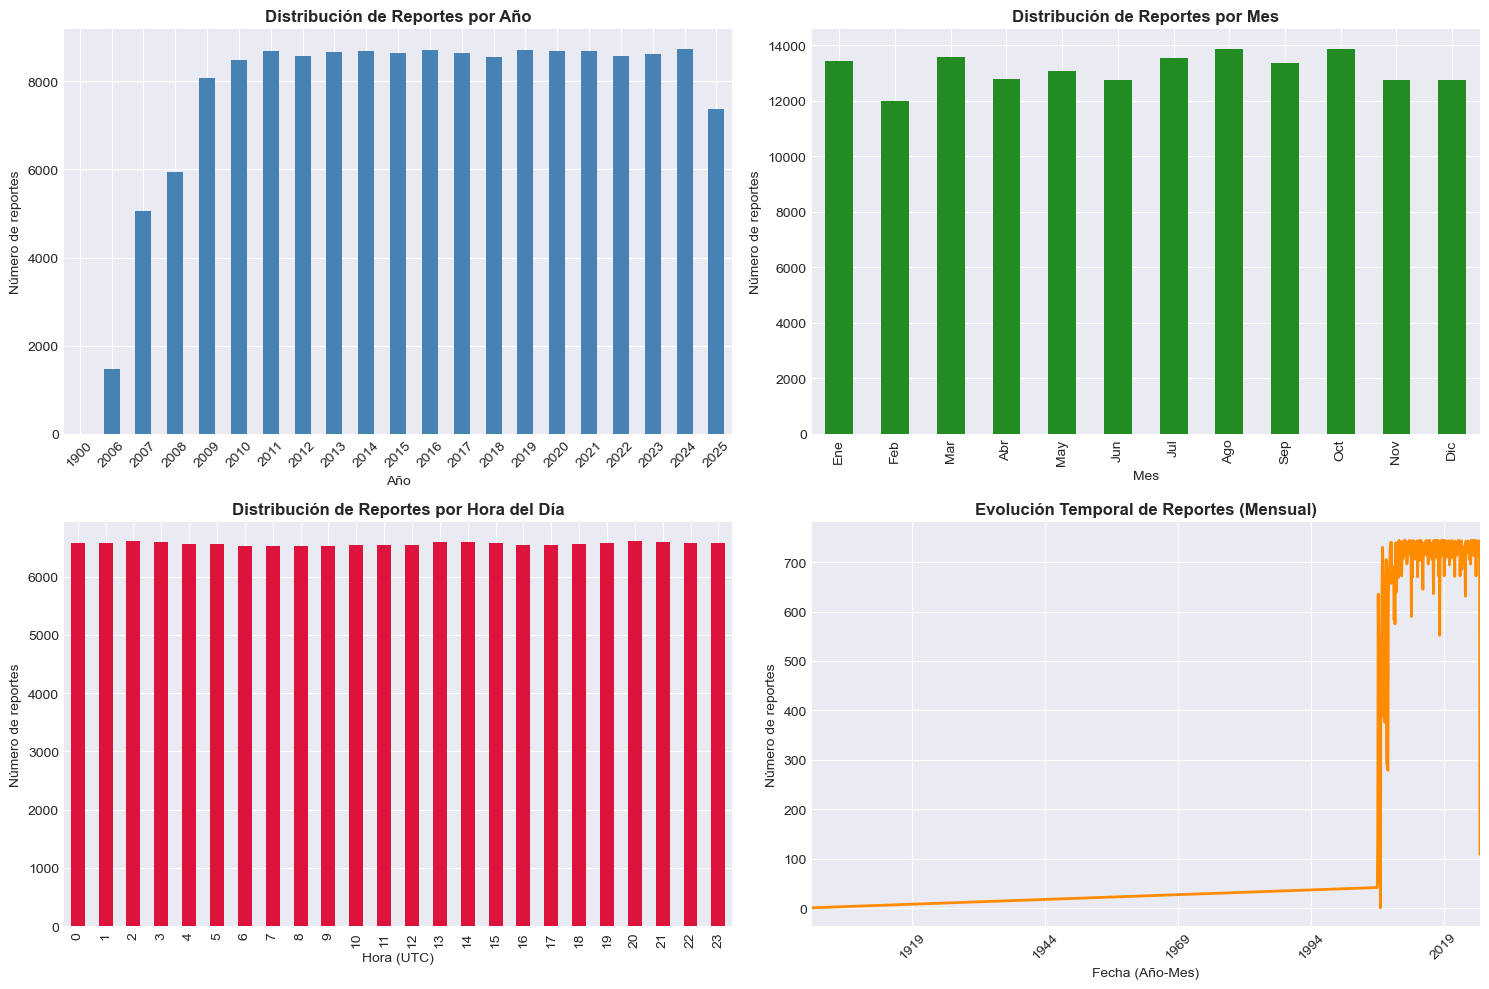

In [40]:
# Análisis de la distribución temporal de los reportes
# Crear FECHA_HORA_REPORTE si no existe
if "FECHA_HORA_REPORTE" not in df_raw.columns:
    df_raw["FECHA_HORA_REPORTE"] = pd.to_datetime(df_raw["FECHA_REPORTE"].astype(str))
    
df_raw["Año"] = df_raw["FECHA_HORA_REPORTE"].dt.year
df_raw["Mes"] = df_raw["FECHA_HORA_REPORTE"].dt.month
df_raw["Dia"] = df_raw["FECHA_HORA_REPORTE"].dt.day
df_raw["Hora"] = df_raw["FECHA_HORA_REPORTE"].dt.hour

# Estadísticas temporales
print("Estadísticas de distribución temporal:")
print(f"\nRango de años: {df_raw['Año'].min()} - {df_raw['Año'].max()}")
print(f"\nDistribución por año:")
print(df_raw['Año'].value_counts().sort_index())

# Gráficos de distribución temporal
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribución por año
df_raw['Año'].value_counts().sort_index().plot(kind='bar', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Distribución de Reportes por Año', fontweight='bold')
axes[0, 0].set_xlabel('Año')
axes[0, 0].set_ylabel('Número de reportes')
axes[0, 0].tick_params(axis='x', rotation=45)

# Distribución por mes
df_raw['Mes'].value_counts().sort_index().plot(kind='bar', ax=axes[0, 1], color='forestgreen')
axes[0, 1].set_title('Distribución de Reportes por Mes', fontweight='bold')
axes[0, 1].set_xlabel('Mes')
axes[0, 1].set_ylabel('Número de reportes')
axes[0, 1].set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
                             'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])

# Distribución por hora del día
df_raw['Hora'].value_counts().sort_index().plot(kind='bar', ax=axes[1, 0], color='crimson')
axes[1, 0].set_title('Distribución de Reportes por Hora del Día', fontweight='bold')
axes[1, 0].set_xlabel('Hora (UTC)')
axes[1, 0].set_ylabel('Número de reportes')

# Serie temporal mensual
df_temporal = df_raw.groupby([df_raw['FECHA_HORA_REPORTE'].dt.to_period('M')]).size()
df_temporal.plot(kind='line', ax=axes[1, 1], color='darkorange', linewidth=2)
axes[1, 1].set_title('Evolución Temporal de Reportes (Mensual)', fontweight='bold')
axes[1, 1].set_xlabel('Fecha (Año-Mes)')
axes[1, 1].set_ylabel('Número de reportes')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [41]:
# contar registros inválidos en TEXTO_REPORTE
invalid_count = df_raw["TEXTO_REPORTE"].str.contains("NIL", na=False).sum()
print(f"Número de registros inválidos en TEXTO_REPORTE: {invalid_count}")

Número de registros inválidos en TEXTO_REPORTE: 4791


In [42]:
df_raw = df_raw[~df_raw["TEXTO_REPORTE"].str.contains("NIL", na=False)]
df_raw.shape

(152844, 14)

**Resultados del análisis temporal:**
- Los datos cubren desde **2006 hasta 2025** (con un registro anómalo del año 1900)
- Hay una distribución relativamente uniforme de reportes a lo largo de los años (8,000-8,700 por año)
- Se observa un registro con fecha 1900 que probablemente sea un error y debería eliminarse
- El análisis mensual y horario ayudará a identificar patrones estacionales y diarios que pueden ser útiles para la predicción


---

## 3. Limpieza y Preparación de Datos

### 3.1 Normalización de columnas de fecha

In [43]:
# Crear columna unificada de fecha y hora
# Las columnas FECHA_REPORTE y HORA_REPORTE contienen información redundante
# Unificamos en una sola columna datetime para facilitar el análisis temporal

df_raw["FECHA_HORA_REPORTE"] = pd.to_datetime(df_raw["FECHA_REPORTE"].astype(str), errors='coerce')

# Verificar conversión
fechas_invalidas = df_raw["FECHA_HORA_REPORTE"].isna().sum()
if fechas_invalidas > 0:
    print(f"  Advertencia: {fechas_invalidas} fechas no pudieron ser convertidas")

print(f" Columna FECHA_HORA_REPORTE creada")
print(f"   Rango: {df_raw['FECHA_HORA_REPORTE'].min()} a {df_raw['FECHA_HORA_REPORTE'].max()}")

# Eliminar registro con fecha 1900 si existe
if df_raw[df_raw['Año'] == 1900].shape[0] > 0:
    registros_eliminados_fecha = len(df_raw[df_raw['Año'] == 1900])
    df_raw = df_raw[df_raw['Año'] != 1900].copy()
    print(f" Eliminados {registros_eliminados_fecha} registros con fecha inválida (1900)")

df_raw[['FECHA_HORA_REPORTE', 'TEXTO_REPORTE']].head()

 Columna FECHA_HORA_REPORTE creada
   Rango: 2006-07-20 00:00:00 a 2025-11-05 13:00:00


,FECHA_HORA_REPORTE,TEXTO_REPORTE
1,2006-07-20 00:00:00,SKBQ 200000Z 03009KT 9999 TS FEW015CB SCT080 28/24 A2983 CB/TS S
2,2006-07-20 01:00:00,SKBQ 200100Z 25008KT 9999 TS FEW015CB SCT080 27/23 A2985
3,2006-07-20 06:00:00,SKBQ 200600Z 29006KT 9999 FEW015 SCT080 26/23 A2985
4,2006-07-20 07:00:00,SKBQ 200700Z 32006KT 9999 SCT012 26/24 A2984
5,2006-07-20 08:00:00,SKBQ 200800Z 27004KT 9999 SCT012 25/23 A2984


### 3.2 Selección de columnas relevantes

Para el análisis, nos enfocamos en las columnas esenciales que contienen información meteorológica relevante.

### 3.3 Análisis de la longitud y complejidad de los reportes

Antes de extraer las variables meteorológicas, analizamos las características del texto de los reportes METAR para entender su estructura.


ANÁLISIS DE LONGITUD Y COMPLEJIDAD DE REPORTES

 Estadísticas descriptivas de longitud de reportes:
       longitud_texto   num_palabras     num_tokens
count   152844.000000  152844.000000  152844.000000
mean        56.468811       8.974157      11.699635
std         11.442734       2.148738       4.076024
min         12.000000       2.000000       2.000000
25%         50.000000       7.000000       9.000000
50%         55.000000       9.000000      11.000000
75%         62.000000      10.000000      14.000000
max        257.000000      40.000000      47.000000

 Análisis de outliers (longitud de texto):
   Q1: 50.0 caracteres
   Q3: 62.0 caracteres
   IQR: 12.0 caracteres
   Registros atípicos: 5600 (3.66%)


C:\Users\edwin\AppData\Local\Temp\ipykernel_35592\3388606711.py:66: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[2].boxplot(box_data, labels=sorted(años_validos), patch_artist=True)


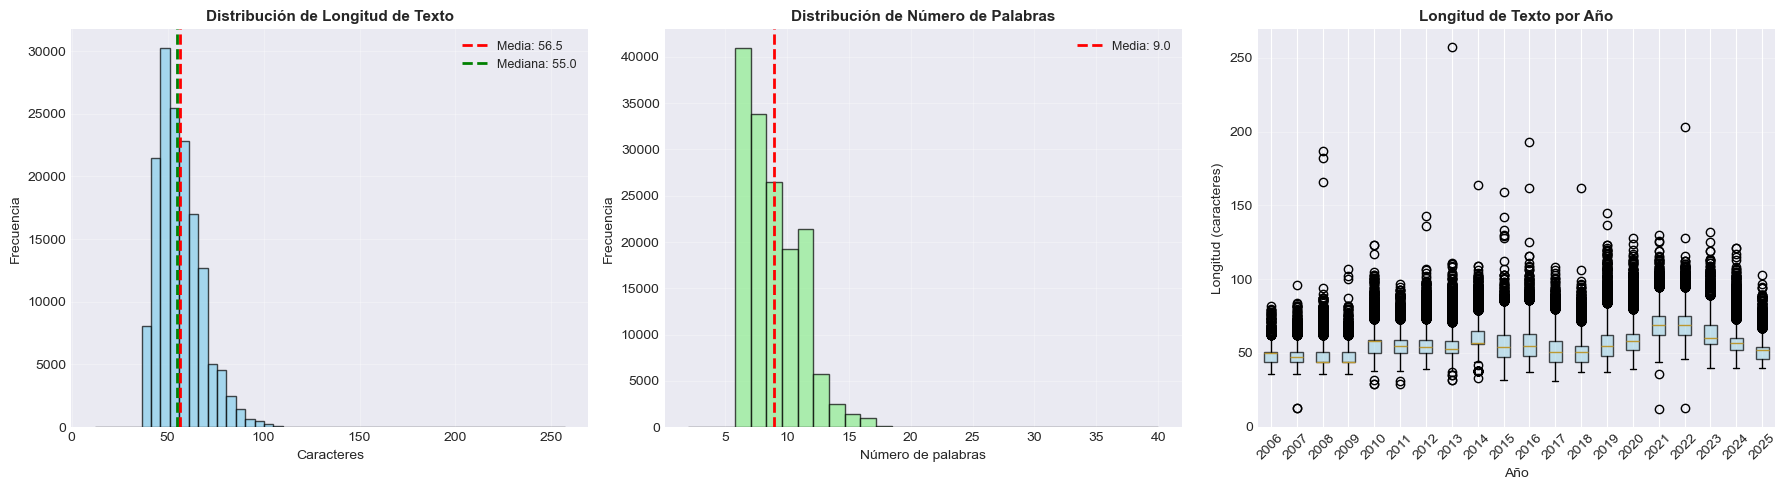


 Ejemplos de reportes:

Reporte más corto (12 caracteres):
  SKBQ 280700Z

Reporte más largo (257 caracteres):
  SKBQ 100600Z METAR SKRH 100600Z METAR SKVP 100600Z METAR SKMR 100600Z METAR SKLC 100600Z METAR SKEJ 100600Z METAR SKBG 100600Z METAR SKCC 100600Z METAR SKUC 100600Z METAR SKMD 100600Z METAR SKRG 100600Z 20004KT  9000 -DZ  BKN008  BKN080  14/14   A3037  RET.


In [44]:
# Análisis de características textuales de los reportes METAR
# Esto nos ayuda a entender la complejidad y variabilidad de los datos

print("=" * 60)
print("ANÁLISIS DE LONGITUD Y COMPLEJIDAD DE REPORTES")
print("=" * 60)

# Calcular métricas de longitud
df_raw['longitud_texto'] = df_raw['TEXTO_REPORTE'].str.len()
df_raw['num_palabras'] = df_raw['TEXTO_REPORTE'].str.split().str.len()
df_raw['num_tokens'] = df_raw['TEXTO_REPORTE'].str.count(' ') + 1

# Estadísticas descriptivas
print("\n Estadísticas descriptivas de longitud de reportes:")
stats_desc = df_raw[['longitud_texto', 'num_palabras', 'num_tokens']].describe()
print(stats_desc.to_string())

# Identificar outliers (valores extremos)
Q1 = df_raw['longitud_texto'].quantile(0.25)
Q3 = df_raw['longitud_texto'].quantile(0.75)
IQR = Q3 - Q1
outliers = df_raw[(df_raw['longitud_texto'] < Q1 - 1.5*IQR) | 
                  (df_raw['longitud_texto'] > Q3 + 1.5*IQR)]
print(f"\n Análisis de outliers (longitud de texto):")
print(f"   Q1: {Q1:.1f} caracteres")
print(f"   Q3: {Q3:.1f} caracteres")
print(f"   IQR: {IQR:.1f} caracteres")
print(f"   Registros atípicos: {len(outliers)} ({len(outliers)/len(df_raw)*100:.2f}%)")

# Visualizaciones
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Distribución de longitud de texto
df_raw['longitud_texto'].hist(bins=50, ax=axes[0], color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribución de Longitud de Texto', fontweight='bold', fontsize=11)
axes[0].set_xlabel('Caracteres', fontsize=10)
axes[0].set_ylabel('Frecuencia', fontsize=10)
mean_len = df_raw['longitud_texto'].mean()
median_len = df_raw['longitud_texto'].median()
axes[0].axvline(mean_len, color='red', linestyle='--', linewidth=2, label=f'Media: {mean_len:.1f}')
axes[0].axvline(median_len, color='green', linestyle='--', linewidth=2, label=f'Mediana: {median_len:.1f}')
axes[0].legend(fontsize=9)
axes[0].grid(alpha=0.3)

# 2. Distribución de número de palabras
df_raw['num_palabras'].hist(bins=30, ax=axes[1], color='lightgreen', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribución de Número de Palabras', fontweight='bold', fontsize=11)
axes[1].set_xlabel('Número de palabras', fontsize=10)
axes[1].set_ylabel('Frecuencia', fontsize=10)
mean_words = df_raw['num_palabras'].mean()
axes[1].axvline(mean_words, color='red', linestyle='--', linewidth=2, 
                label=f'Media: {mean_words:.1f}')
axes[1].legend(fontsize=9)
axes[1].grid(alpha=0.3)

# 3. Boxplot de longitud por año (si hay múltiples años)
if 'Año' in df_raw.columns and df_raw['Año'].nunique() > 1:
    # Filtrar años con suficientes datos
    años_validos = df_raw['Año'].value_counts()
    años_validos = años_validos[años_validos > 100].index
    df_temp = df_raw[df_raw['Año'].isin(años_validos)]
    
    if len(años_validos) > 1:
        box_data = [df_temp[df_temp['Año'] == año]['longitud_texto'].values 
                   for año in sorted(años_validos)]
        bp = axes[2].boxplot(box_data, labels=sorted(años_validos), patch_artist=True)
        axes[2].set_title('Longitud de Texto por Año', fontweight='bold', fontsize=11)
        axes[2].set_xlabel('Año', fontsize=10)
        axes[2].set_ylabel('Longitud (caracteres)', fontsize=10)
        axes[2].tick_params(axis='x', rotation=45)
        axes[2].grid(alpha=0.3, axis='y')
        
        # Colorear los boxes
        for patch in bp['boxes']:
            patch.set_facecolor('lightblue')
            patch.set_alpha(0.7)
    else:
        df_raw['num_tokens'].hist(bins=30, ax=axes[2], color='salmon', edgecolor='black', alpha=0.7)
        axes[2].set_title('Distribución de Número de Tokens', fontweight='bold', fontsize=11)
        axes[2].set_xlabel('Número de tokens', fontsize=10)
        axes[2].set_ylabel('Frecuencia', fontsize=10)
        axes[2].grid(alpha=0.3)
else:
    df_raw['num_tokens'].hist(bins=30, ax=axes[2], color='salmon', edgecolor='black', alpha=0.7)
    axes[2].set_title('Distribución de Número de Tokens', fontweight='bold', fontsize=11)
    axes[2].set_xlabel('Número de tokens', fontsize=10)
    axes[2].set_ylabel('Frecuencia', fontsize=10)
    axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Mostrar ejemplos de reportes con longitudes extremas
print(f"\n Ejemplos de reportes:")
print(f"\nReporte más corto ({df_raw['longitud_texto'].min()} caracteres):")
print(f"  {df_raw.loc[df_raw['longitud_texto'].idxmin(), 'TEXTO_REPORTE']}")
print(f"\nReporte más largo ({df_raw['longitud_texto'].max()} caracteres):")
print(f"  {df_raw.loc[df_raw['longitud_texto'].idxmax(), 'TEXTO_REPORTE']}")


**Resultados del análisis de longitud:**
- **Longitud promedio:** ~56.5 caracteres por reporte
- **Número promedio de palabras:** ~9 palabras
- **Rango:** Los reportes varían entre 12 y 257 caracteres
- La distribución es relativamente normal, lo que indica consistencia en el formato METAR
- Los outliers pueden indicar reportes con información adicional (fenómenos meteorológicos especiales)


In [45]:
# Configurar pandas para mostrar el texto completo de las columnas
# Útil para inspeccionar los reportes METAR completos
pd.set_option('display.max_colwidth', None)
print(" Configuración de visualización actualizada")


 Configuración de visualización actualizada


In [46]:
# Seleccionar solo las columnas esenciales para el procesamiento
# Mantenemos FECHA_HORA_REPORTE (temporal) y TEXTO_REPORTE (del cual extraeremos variables)
columnas_mantenidas = ["FECHA_HORA_REPORTE", "TEXTO_REPORTE"]
df_raw = df_raw[columnas_mantenidas].copy()

print(f" Columnas seleccionadas: {columnas_mantenidas}")
print(f"   Forma del dataset: {df_raw.shape}")
print("\nPrimeras filas:")
df_raw.head()

 Columnas seleccionadas: ['FECHA_HORA_REPORTE', 'TEXTO_REPORTE']
   Forma del dataset: (152844, 2)

Primeras filas:


,FECHA_HORA_REPORTE,TEXTO_REPORTE
1,2006-07-20 00:00:00,SKBQ 200000Z 03009KT 9999 TS FEW015CB SCT080 28/24 A2983 CB/TS S
2,2006-07-20 01:00:00,SKBQ 200100Z 25008KT 9999 TS FEW015CB SCT080 27/23 A2985
3,2006-07-20 06:00:00,SKBQ 200600Z 29006KT 9999 FEW015 SCT080 26/23 A2985
4,2006-07-20 07:00:00,SKBQ 200700Z 32006KT 9999 SCT012 26/24 A2984
5,2006-07-20 08:00:00,SKBQ 200800Z 27004KT 9999 SCT012 25/23 A2984


---

## 4. Extracción de Variables Meteorológicas

Los reportes METAR siguen un formato estándar. Extraeremos las siguientes variables:
- **Aeródromo:** Código del aeropuerto
- **Fecha Zulu:** Fecha/hora del reporte en tiempo UTC
- **Viento:** Dirección y velocidad del viento
- **Visibilidad:** Distancia de visibilidad
- **Temperatura/Punto de rocío:** Temperatura del aire y punto de rocío
- **Presión:** Presión atmosférica
- **Nubosidad:** Tipos y alturas de nubes
- **Fenómenos:** Fenómenos meteorológicos observados

In [47]:
# Paso 1: Tokenizar el texto del reporte METAR
# Los reportes METAR tienen un formato estructurado donde cada espacio separa un token
df_raw["tokens"] = df_raw["TEXTO_REPORTE"].str.split()

print(f" Texto tokenizado")
print(f"   Ejemplo de tokens: {df_raw['tokens'].iloc[0][:5]}...")  # Mostrar primeros 5 tokens

df_raw[['TEXTO_REPORTE', 'tokens']].head(3)

 Texto tokenizado
   Ejemplo de tokens: ['SKBQ', '200000Z', '03009KT', '9999', 'TS']...


,TEXTO_REPORTE,tokens
1,SKBQ 200000Z 03009KT 9999 TS FEW015CB SCT080 28/24 A2983 CB/TS S,"[SKBQ, 200000Z, 03009KT, 9999, TS, FEW015CB, SCT080, 28/24, A2983, CB/TS, S]"
2,SKBQ 200100Z 25008KT 9999 TS FEW015CB SCT080 27/23 A2985,"[SKBQ, 200100Z, 25008KT, 9999, TS, FEW015CB, SCT080, 27/23, A2985]"
3,SKBQ 200600Z 29006KT 9999 FEW015 SCT080 26/23 A2985,"[SKBQ, 200600Z, 29006KT, 9999, FEW015, SCT080, 26/23, A2985]"


In [48]:
# Paso 2: Extracción de variables meteorológicas usando parsing estructurado
# Los reportes METAR siguen un formato estándar: AERODROMO FECHAZ VENTO VISIBILIDAD TEMP/ROCIO PRESION NUBOSIDAD FENOMENOS

print("Extrayendo variables meteorológicas...")

# Variables básicas (por posición en el tokenizado)
df_raw["aerodromo"] = df_raw["tokens"].str[0]      # Primer token: código del aeródromo
df_raw["fecha_zulu"] = df_raw["tokens"].str[1]     # Segundo token: fecha Zulu
df_raw["viento"] = df_raw["tokens"].str[2]         # Tercer token: viento
df_raw["visibilidad"] = df_raw["tokens"].str[3]    # Cuarto token: visibilidad

# Variables usando expresiones regulares (no siempre están en posiciones fijas)
# Temperatura y punto de rocío: formato DD/DD (dos dígitos/dos dígitos)
df_raw["temperatura/rocio"] = df_raw["TEXTO_REPORTE"].str.extract(r'(\d{2}\/\d{2})')

# Presión: formato A#### (A seguido de 4 dígitos)
df_raw["presion"] = df_raw["TEXTO_REPORTE"].str.extract(r'(A\d{4})')

# Nubosidad: códigos estándar METAR (FEW/SCT/BKN/OVC seguidos de altura)
# FEW = Few (pocas nubes), SCT = Scattered (dispersas), BKN = Broken (rotas), OVC = Overcast (cubierto)
df_raw["nubosidad"] = df_raw["TEXTO_REPORTE"].str.findall(r'(FEW\d{3}\w*|SCT\d{3}\w*|BKN\d{3}\w*|OVC\d{3}\w*)').str.join(", ")

# Fenómenos meteorológicos: códigos estándar
# TS=Tormenta, RA=Lluvia, SHRA=Chubasco de lluvia, FG=Neblina, BR=Neblina ligera, 
# HZ=Calina, CB=Cumulonimbus, VC*=Variaciones cercanas
df_raw["fenomenos"] = df_raw["TEXTO_REPORTE"].str.findall(r'\b(TS|RA|SHRA|FG|BR|HZ|CB|VC\w+)\b').str.join(", ")

print(" Variables extraídas:")
print(f"   - Aeródromo")
print(f"   - Fecha Zulu")
print(f"   - Viento")
print(f"   - Visibilidad")
print(f"   - Temperatura/Rocío")
print(f"   - Presión")
print(f"   - Nubosidad")
print(f"   - Fenómenos meteorológicos")

# Verificar extracción con ejemplo
print("\n Ejemplo de extracción:")
ejemplo_idx = 0
print(f"   Reporte original: {df_raw['TEXTO_REPORTE'].iloc[ejemplo_idx]}")
print(f"   Aeródromo: {df_raw['aerodromo'].iloc[ejemplo_idx]}")
print(f"   Viento: {df_raw['viento'].iloc[ejemplo_idx]}")
print(f"   Visibilidad: {df_raw['visibilidad'].iloc[ejemplo_idx]}")
print(f"   Presión: {df_raw['presion'].iloc[ejemplo_idx]}")
print(f"   Nubosidad: {df_raw['nubosidad'].iloc[ejemplo_idx]}")
print(f"   Fenómenos: {df_raw['fenomenos'].iloc[ejemplo_idx]}")

Extrayendo variables meteorológicas...
 Variables extraídas:
   - Aeródromo
   - Fecha Zulu
   - Viento
   - Visibilidad
   - Temperatura/Rocío
   - Presión
   - Nubosidad
   - Fenómenos meteorológicos

 Ejemplo de extracción:
   Reporte original: SKBQ 200000Z 03009KT 9999 TS FEW015CB SCT080 28/24 A2983 CB/TS S
   Aeródromo: SKBQ
   Viento: 03009KT
   Visibilidad: 9999
   Presión: A2983
   Nubosidad: FEW015CB, SCT080
   Fenómenos: TS, CB, TS


---

## 5. Análisis de las Variables Extraídas

Ahora analizamos la calidad y distribución de las variables meteorológicas extraídas.


In [49]:
# Análisis exhaustivo de las variables meteorológicas extraídas
# Evaluamos completitud, distribución y calidad de los datos

print("=" * 70)
print("ESTADÍSTICAS DESCRIPTIVAS DE VARIABLES EXTRAÍDAS")
print("=" * 70)

# 1. Análisis de aeródromos
print("\n  AERÓDROMOS:")
print(f"   Total de aeródromos únicos: {df_raw['aerodromo'].nunique()}")
print(f"   Distribución de aeródromos:")
aerodromos_dist = df_raw['aerodromo'].value_counts()
print(aerodromos_dist.to_string())

ESTADÍSTICAS DESCRIPTIVAS DE VARIABLES EXTRAÍDAS

  AERÓDROMOS:
   Total de aeródromos únicos: 1
   Distribución de aeródromos:
aerodromo
SKBQ    152844


In [50]:
# 2. Análisis de valores faltantes
columnas_extraidas = ["aerodromo", "fecha_zulu", "viento", "visibilidad", 
                      "nubosidad", "temperatura/rocio", "presion", "fenomenos"]

print("\n  VALORES FALTANTES EN COLUMNAS EXTRAÍDAS:")
missing_extracted = df_raw[columnas_extraidas].isna().sum()
missing_extracted_pct = (missing_extracted / len(df_raw)) * 100
missing_extracted_df = pd.DataFrame({
    'Valores faltantes': missing_extracted,
    'Porcentaje': missing_extracted_pct,
    'Completitud (%)': 100 - missing_extracted_pct
})
print(missing_extracted_df.to_string(index=True))


  VALORES FALTANTES EN COLUMNAS EXTRAÍDAS:
                   Valores faltantes  Porcentaje  Completitud (%)
aerodromo                          0    0.000000       100.000000
fecha_zulu                         0    0.000000       100.000000
viento                             4    0.002617        99.997383
visibilidad                        4    0.002617        99.997383
nubosidad                          0    0.000000       100.000000
temperatura/rocio               1156    0.756327        99.243673
presion                        21084   13.794457        86.205543
fenomenos                          0    0.000000       100.000000


In [51]:
# 3. Análisis de valores únicos (cardinalidad)
print("\n  CARDINALIDAD DE VARIABLES (valores únicos):")
for col in columnas_extraidas:
    n_unicos = df_raw[col].nunique()
    print(f"   {col:20s}: {n_unicos:>6,} valores únicos")


  CARDINALIDAD DE VARIABLES (valores únicos):
   aerodromo           :      1 valores únicos
   fecha_zulu          :  1,235 valores únicos
   viento              :  1,659 valores únicos
   visibilidad         :    962 valores únicos
   nubosidad           :  2,927 valores únicos
   temperatura/rocio   :    288 valores únicos
   presion             :    152 valores únicos
   fenomenos           :    132 valores únicos


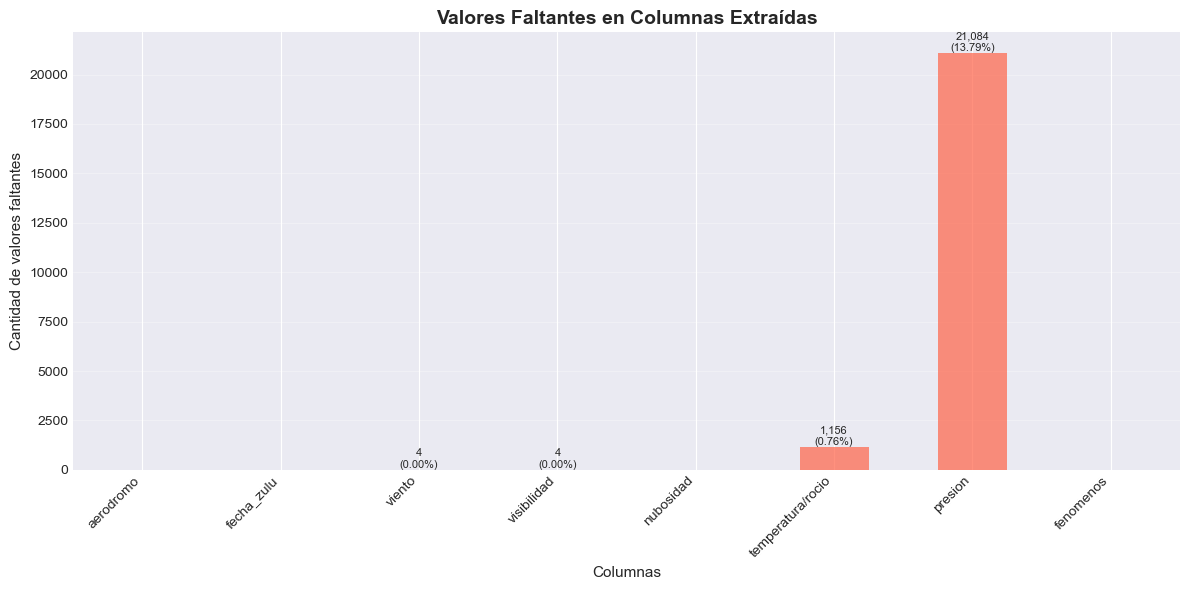

In [52]:
# Visualización de valores faltantes
fig, ax = plt.subplots(figsize=(12, 6))
if missing_extracted.sum() > 0:
    bars = missing_extracted.plot(kind='bar', ax=ax, color='tomato', alpha=0.7)
    ax.set_title('Valores Faltantes en Columnas Extraídas', fontsize=14, fontweight='bold')
    ax.set_ylabel('Cantidad de valores faltantes', fontsize=11)
    ax.set_xlabel('Columnas', fontsize=11)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    
    # Agregar etiquetas con porcentajes
    for i, (idx, val) in enumerate(missing_extracted.items()):
        if val > 0:
            ax.text(i, val, f'{val:,}\n({missing_extracted_pct[idx]:.2f}%)', 
                   ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
else:
    print("\n No hay valores faltantes en las columnas extraídas")


**Resultados del análisis de variables extraídas:**
- **Aeródromo:** Solo un aeródromo (SKBQ), todos los reportes son del mismo aeropuerto
- **Completitud:**
  - Variables con 100% completitud: aeródromo, fecha_zulu, nubosidad, fenómenos
  - Viento y visibilidad: ~99.99% completitud (solo 4 valores faltantes)
  - Temperatura/Rocío: ~99.24% completitud (1,156 faltantes - 0.76%)
  - Presión: ~86.21% completitud (21,084 faltantes - 13.79%) - **Variable crítica con mayor pérdida de datos**
- La presión tiene la mayor tasa de valores faltantes, lo cual podría requerir estrategias de imputación o tratamiento especial


### 5.1 Análisis detallado de fenómenos meteorológicos

Los fenómenos meteorológicos son eventos específicos que pueden afectar significativamente las operaciones aéreas y son importantes para la predicción.


In [53]:
# Análisis detallado de fenómenos meteorológicos
# Los fenómenos son eventos importantes que pueden afectar la predicción de cizalladura

print("=" * 70)
print("ANÁLISIS DE FENÓMENOS METEOROLÓGICOS")
print("=" * 70)

# Contar registros con y sin fenómenos
sin_fenomenos = df_raw['fenomenos'].isna().sum() + (df_raw['fenomenos'] == '').sum()
con_fenomenos = len(df_raw) - sin_fenomenos
porcentaje_con = (con_fenomenos / len(df_raw)) * 100
porcentaje_sin = (sin_fenomenos / len(df_raw)) * 100

print(f"\n Distribución general:")
print(f"   Registros con fenómenos meteorológicos: {con_fenomenos:,} ({porcentaje_con:.2f}%)")
print(f"   Registros sin fenómenos meteorológicos: {sin_fenomenos:,} ({porcentaje_sin:.2f}%)")

# Contar fenómenos individuales (puede haber múltiples fenómenos por registro)
fenomenos_list = []
for idx, row in df_raw.iterrows():
    if pd.notna(row['fenomenos']) and str(row['fenomenos']) != '':
        # Separar fenómenos múltiples (separados por comas)
        fenomenos_individuales = [f.strip() for f in str(row['fenomenos']).split(',')]
        fenomenos_list.extend(fenomenos_individuales)

fenomenos_series = pd.Series(fenomenos_list)
fenomenos_counts = fenomenos_series.value_counts().head(20)

print(f"\n Top 20 fenómenos meteorológicos (por frecuencia):")
print(fenomenos_counts.to_string())

ANÁLISIS DE FENÓMENOS METEOROLÓGICOS

 Distribución general:
   Registros con fenómenos meteorológicos: 25,530 (16.70%)
   Registros sin fenómenos meteorológicos: 127,314 (83.30%)

 Top 20 fenómenos meteorológicos (por frecuencia):
VCSH       7123
CB         6735
BR         6350
VCFG       5641
HZ         3523
RA         1553
TS          695
VCTS        302
FG          292
SHRA         10
VCSG          4
VCH           3
VCG           2
VCHS          2
VCF6          2
VCBR          2
VCSHN         1
VCS           1
VCRA          1
VCSHINE       1


In [54]:
# Análisis adicional: frecuencia de múltiples fenómenos simultáneos
num_fenomenos_por_registro = df_raw[df_raw['fenomenos'].notna() & (df_raw['fenomenos'] != '')]['fenomenos'].apply(
    lambda x: len(str(x).split(','))
)
print(f"\n Estadísticas de fenómenos múltiples:")
print(f"   Promedio de fenómenos por registro (cuando hay fenómenos): {num_fenomenos_por_registro.mean():.2f}")
print(f"   Máximo de fenómenos en un registro: {num_fenomenos_por_registro.max()}")


 Estadísticas de fenómenos múltiples:
   Promedio de fenómenos por registro (cuando hay fenómenos): 1.26
   Máximo de fenómenos en un registro: 6


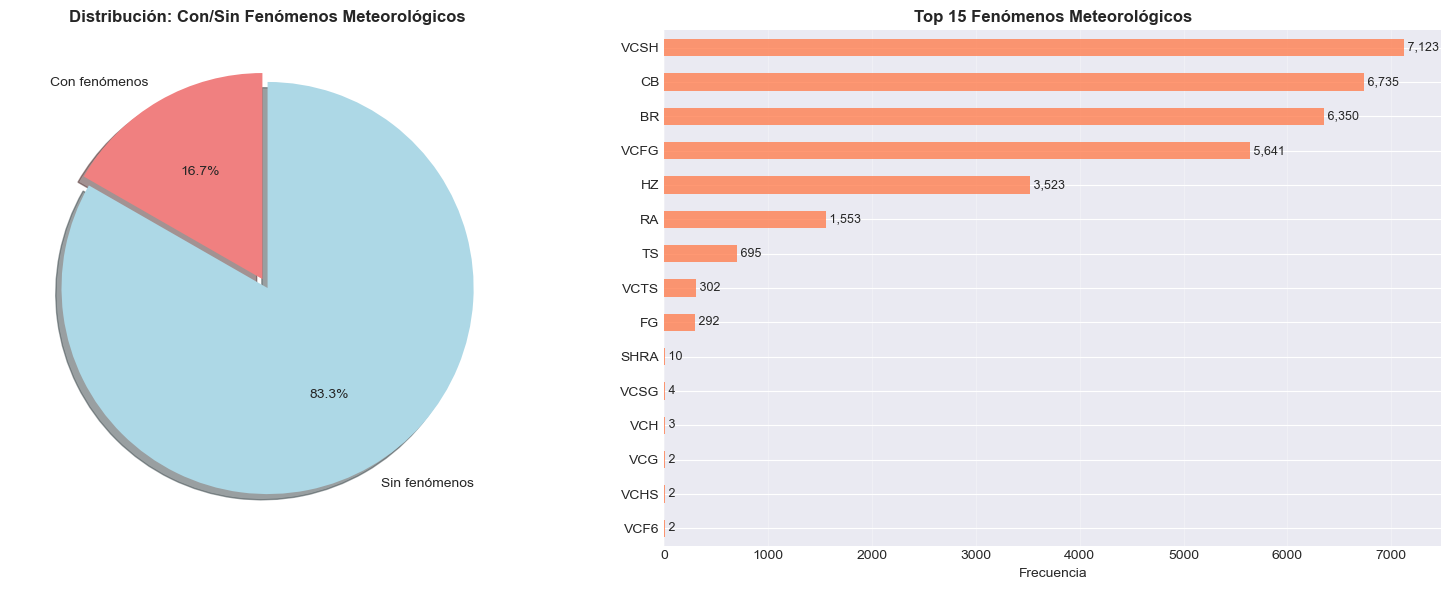


 Interpretación de fenómenos más frecuentes:

   Fenómenos más comunes y su significado:
   VCSH  : Chubascos en las cercanías
   CB    : Cumulonimbus (nubes de tormenta)
   BR    : Neblina ligera (Bruma)
   VCFG  : Niebla en las cercanías
   HZ    : Calina (Haze)
   RA    : Lluvia
   TS    : Tormenta eléctrica
   VCTS  : Tormenta en las cercanías
   FG    : Niebla densa


In [55]:
# Visualizaciones
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Distribución con/sin fenómenos
labels = ['Con fenómenos', 'Sin fenómenos']
sizes = [con_fenomenos, sin_fenomenos]
colors = ['lightcoral', 'lightblue']
explode = (0.05, 0)  # Separar ligeramente la porción de "con fenómenos"

axes[0].pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, 
            startangle=90, explode=explode, shadow=True)
axes[0].set_title('Distribución: Con/Sin Fenómenos Meteorológicos', 
                  fontweight='bold', fontsize=12)

# 2. Top fenómenos
if len(fenomenos_counts) > 0:
    fenomenos_counts.head(15).plot(kind='barh', ax=axes[1], color='coral', alpha=0.8)
    axes[1].set_title('Top 15 Fenómenos Meteorológicos', fontweight='bold', fontsize=12)
    axes[1].set_xlabel('Frecuencia', fontsize=10)
    axes[1].invert_yaxis()
    axes[1].grid(axis='x', alpha=0.3)
    
    # Agregar etiquetas de valores
    for i, v in enumerate(fenomenos_counts.head(15).values):
        axes[1].text(v, i, f' {v:,}', va='center', fontsize=9)
else:
    axes[1].text(0.5, 0.5, 'No hay fenómenos registrados', 
                ha='center', va='center', fontsize=12)
    axes[1].set_title('Fenómenos Meteorológicos', fontweight='bold')

plt.tight_layout()
plt.show()

# Interpretación de códigos más frecuentes
print("\n Interpretación de fenómenos más frecuentes:")
interpretacion = {
    'VCSH': 'Chubascos en las cercanías',
    'CB': 'Cumulonimbus (nubes de tormenta)',
    'BR': 'Neblina ligera (Bruma)',
    'VCFG': 'Niebla en las cercanías',
    'HZ': 'Calina (Haze)',
    'RA': 'Lluvia',
    'TS': 'Tormenta eléctrica',
    'VCTS': 'Tormenta en las cercanías',
    'FG': 'Niebla densa'
}
print("\n   Fenómenos más comunes y su significado:")
for codigo in fenomenos_counts.head(10).index:
    if codigo in interpretacion:
        print(f"   {codigo:6s}: {interpretacion[codigo]}")


**Resultados del análisis de fenómenos meteorológicos:**
- Solo el **16.70%** de los registros presentan fenómenos meteorológicos
- El **83.30%** de los reportes no tienen fenómenos registrados
- **Fenómenos más comunes:**
  1. **VCSH** (Chubascos en las cercanías): 7,123 ocurrencias
  2. **CB** (Cumulonimbus): 6,735 ocurrencias - **Importante para cizalladura**
  3. **BR** (Neblina ligera): 6,350 ocurrencias
  4. **VCFG** (Niebla en las cercanías): 5,641 ocurrencias
  5. **HZ** (Calina): 3,523 ocurrencias
- Los fenómenos relacionados con tormentas (TS, CB, VCTS) son relevantes para la predicción de cizalladura del viento


### 5.2 Análisis detallado de nubosidad

La nubosidad proporciona información sobre las condiciones atmosféricas y puede estar relacionada con fenómenos de cizalladura.


ANÁLISIS DE NUBOSIDAD

 Disponibilidad de datos de nubosidad:
   Registros con información de nubosidad: 120,965 (79.14%)
   Registros sin información de nubosidad: 31,879 (20.86%)

  Distribución de tipos de nubosidad:
SCT    80356
FEW    57235
BKN    35954
OVC     1994

 Significado de los tipos:
   FEW: Few - Pocas nubes (1-2 octavos del cielo) (57,235 ocurrencias)
   SCT: Scattered - Dispersas (3-4 octavos) (80,356 ocurrencias)
   BKN: Broken - Rotas (5-7 octavos) (35,954 ocurrencias)
   OVC: Overcast - Cubierto (8 octavos, cielo cubierto) (1,994 ocurrencias)

 Análisis de alturas de nubosidad (en pies):
   Altura mínima: 0 pies
   Altura máxima: 97,900 pies
   Altura promedio: 4,884 pies
   Altura mediana: 1,500 pies


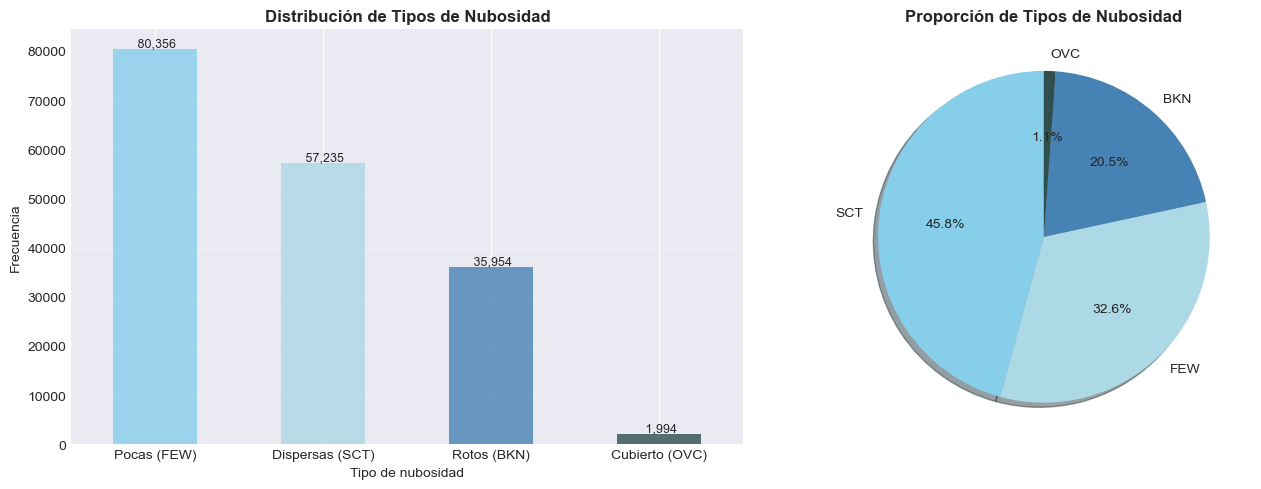


 Análisis de capas de nubes:
   Promedio de capas por registro: 1.45
   Máximo de capas en un registro: 6
   Registros con múltiples capas: 51,573 (42.63%)


In [56]:
# Análisis detallado de nubosidad
# La nubosidad puede indicar condiciones atmosféricas que favorecen la cizalladura

print("=" * 70)
print("ANÁLISIS DE NUBOSIDAD")
print("=" * 70)

sin_nubosidad = df_raw['nubosidad'].isna().sum() + (df_raw['nubosidad'] == '').sum()
con_nubosidad = len(df_raw) - sin_nubosidad
porcentaje_con = (con_nubosidad / len(df_raw)) * 100
porcentaje_sin = (sin_nubosidad / len(df_raw)) * 100

print(f"\n Disponibilidad de datos de nubosidad:")
print(f"   Registros con información de nubosidad: {con_nubosidad:,} ({porcentaje_con:.2f}%)")
print(f"   Registros sin información de nubosidad: {sin_nubosidad:,} ({porcentaje_sin:.2f}%)")

# Extraer tipos de nubosidad
# Los códigos METAR son: FEW (Few/Pocas), SCT (Scattered/Dispersas), 
# BKN (Broken/Rotas), OVC (Overcast/Cubierto)
nubosidad_tipos = []
alturas_nubosidad = []

for idx, row in df_raw.iterrows():
    if pd.notna(row['nubosidad']) and str(row['nubosidad']) != '':
        # Extraer tipos (FEW, SCT, BKN, OVC)
        tipos = re.findall(r'(FEW|SCT|BKN|OVC)', str(row['nubosidad']))
        nubosidad_tipos.extend(tipos)
        
        # Extraer alturas (3 dígitos después del tipo)
        alturas = re.findall(r'(?:FEW|SCT|BKN|OVC)(\d{3})', str(row['nubosidad']))
        alturas_nubosidad.extend([int(h) * 100 for h in alturas])  # Convertir a pies

if nubosidad_tipos:
    nubosidad_series = pd.Series(nubosidad_tipos)
    nubosidad_counts = nubosidad_series.value_counts()
    
    print(f"\n  Distribución de tipos de nubosidad:")
    print(nubosidad_counts.to_string())
    
    # Interpretación de tipos
    interpretacion_tipos = {
        'FEW': 'Few - Pocas nubes (1-2 octavos del cielo)',
        'SCT': 'Scattered - Dispersas (3-4 octavos)',
        'BKN': 'Broken - Rotas (5-7 octavos)',
        'OVC': 'Overcast - Cubierto (8 octavos, cielo cubierto)'
    }
    
    print(f"\n Significado de los tipos:")
    for tipo, desc in interpretacion_tipos.items():
        if tipo in nubosidad_counts.index:
            print(f"   {tipo}: {desc} ({nubosidad_counts[tipo]:,} ocurrencias)")
    
    # Análisis de alturas
    if alturas_nubosidad:
        alturas_series = pd.Series(alturas_nubosidad)
        print(f"\n Análisis de alturas de nubosidad (en pies):")
        print(f"   Altura mínima: {alturas_series.min():,} pies")
        print(f"   Altura máxima: {alturas_series.max():,} pies")
        print(f"   Altura promedio: {alturas_series.mean():,.0f} pies")
        print(f"   Altura mediana: {alturas_series.median():,.0f} pies")
    
    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Gráfico de barras con colores diferenciados
    colores_nubosidad = {'FEW': 'lightblue', 'SCT': 'skyblue', 'BKN': 'steelblue', 'OVC': 'darkslategray'}
    nubosidad_counts.plot(kind='bar', ax=axes[0], 
                         color=[colores_nubosidad.get(x, 'gray') for x in nubosidad_counts.index],
                         alpha=0.8)
    axes[0].set_title('Distribución de Tipos de Nubosidad', fontweight='bold', fontsize=12)
    axes[0].set_xlabel('Tipo de nubosidad', fontsize=10)
    axes[0].set_ylabel('Frecuencia', fontsize=10)
    axes[0].set_xticklabels(['Pocas (FEW)', 'Dispersas (SCT)', 
                             'Rotos (BKN)', 'Cubierto (OVC)'], rotation=0)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Agregar etiquetas de valores
    for i, v in enumerate(nubosidad_counts.values):
        axes[0].text(i, v, f' {v:,}', ha='center', va='bottom', fontsize=9)
    
    # Gráfico de pastel
    axes[1].pie(nubosidad_counts.values, labels=nubosidad_counts.index, 
                autopct='%1.1f%%', startangle=90, 
                colors=[colores_nubosidad.get(x, 'gray') for x in nubosidad_counts.index],
                shadow=True)
    axes[1].set_title('Proporción de Tipos de Nubosidad', fontweight='bold', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Análisis de nubosidad múltiple (múltiples capas)
    num_capas = df_raw[df_raw['nubosidad'].notna() & (df_raw['nubosidad'] != '')]['nubosidad'].apply(
        lambda x: len(re.findall(r'(FEW|SCT|BKN|OVC)', str(x)))
    )
    print(f"\n Análisis de capas de nubes:")
    print(f"   Promedio de capas por registro: {num_capas.mean():.2f}")
    print(f"   Máximo de capas en un registro: {num_capas.max()}")
    print(f"   Registros con múltiples capas: {(num_capas > 1).sum():,} ({(num_capas > 1).sum()/len(num_capas)*100:.2f}%)")
else:
    print("\n  No se encontraron tipos de nubosidad en los datos")


**Resultados del análisis de nubosidad:**
- **79.14%** de los registros tienen información de nubosidad
- **20.86%** no tienen información (puede indicar cielo despejado o datos faltantes)
- **Distribución de tipos:**
  1. **SCT (Dispersas)**: 80,356 ocurrencias - más común
  2. **FEW (Pocas)**: 57,235 ocurrencias
  3. **BKN (Rotas)**: 35,954 ocurrencias
  4. **OVC (Cubierto)**: 1,994 ocurrencias - menos común
- La mayoría de los reportes tienen nubes dispersas o pocas, lo que indica condiciones generalmente despejadas
- Los reportes pueden tener múltiples capas de nubes (información importante para predicción)


### 5.3 Análisis de visibilidad y viento

El viento y la visibilidad son variables críticas para la predicción de cizalladura del viento.


In [57]:
# Análisis detallado de visibilidad y viento
# Estas son variables críticas para la predicción de cizalladura del viento

print("=" * 70)
print("ANÁLISIS DE VISIBILIDAD Y VIENTO")
print("=" * 70)

# ========== ANÁLISIS DE VISIBILIDAD ==========
print("\n ANÁLISIS DE VISIBILIDAD:")
print("   Distribución de valores de visibilidad (Top 15):")
visibilidad_dist = df_raw['visibilidad'].value_counts().head(15)
print(visibilidad_dist.to_string())

# Interpretar valores especiales
valores_especiales = {
    '9999': 'Visibilidad >= 10 km (visibilidad excelente)',
    'CAVOK': 'Ceiling And Visibility OK (techo y visibilidad OK)',
    '8000': '8 km',
    '7000': '7 km',
    '6000': '5 km',
    '5000': '5 km',
    '4000': '4 km'
}

print("\n   Interpretación de valores comunes:")
for val, desc in list(valores_especiales.items())[:5]:
    if val in visibilidad_dist.index:
        count = visibilidad_dist[val]
        print(f"   {val:10s}: {desc:50s} ({count:,} registros)")

# Estadísticas de visibilidad numérica (excluyendo CAVOK y valores no numéricos)
visibilidad_numerica = df_raw[df_raw['visibilidad'] != 'CAVOK']['visibilidad'].str.extract(r'^(\d+)')
visibilidad_numerica = visibilidad_numerica[0].dropna().astype(int)
if len(visibilidad_numerica) > 0:
    print(f"\n   Estadísticas de visibilidad numérica (en metros):")
    print(f"   Valores únicos: {df_raw['visibilidad'].nunique()}")
    print(f"   Rango: {visibilidad_numerica.min():,} - {visibilidad_numerica.max():,} metros")
    print(f"   Promedio: {visibilidad_numerica.mean():,.0f} metros")
    print(f"   Mediana: {visibilidad_numerica.median():,.0f} metros")



ANÁLISIS DE VISIBILIDAD Y VIENTO

 ANÁLISIS DE VISIBILIDAD:
   Distribución de valores de visibilidad (Top 15):
visibilidad
9999       81228
CAVOK      25380
8000        6622
7000        2652
350V050     2161
6000        2134
5000        2048
4000        1897
360V060     1603
340V050     1225
3000        1171
330V030     1118
350V060      861
340V040      754
330V050      750

   Interpretación de valores comunes:
   9999      : Visibilidad >= 10 km (visibilidad excelente)       (81,228 registros)
   CAVOK     : Ceiling And Visibility OK (techo y visibilidad OK) (25,380 registros)
   8000      : 8 km                                               (6,622 registros)
   7000      : 7 km                                               (2,652 registros)
   6000      : 5 km                                               (2,134 registros)

   Estadísticas de visibilidad numérica (en metros):
   Valores únicos: 962
   Rango: 0 - 3,501,060 metros
   Promedio: 7,480 metros
   Mediana: 9,999 metros


In [58]:
# ========== ANÁLISIS DE VIENTO ==========
print("\n ANÁLISIS DE VIENTO:")
print("   Distribución de valores de viento (Top 15):")
viento_dist = df_raw['viento'].value_counts().head(15)
print(viento_dist.to_string())

# Interpretar formato de viento: DDDSSKT donde DDD=dirección, SS=velocidad, KT=nudos
# Ejemplo: 03008KT = viento de 030° (noreste) a 8 nudos
# VRB02KT = viento variable (variable direction) a 2 nudos
# 00000KT = calma (sin viento)

print("\n   Interpretación del formato:")
print("   - Formato: DDDSSKT (dirección en grados + velocidad en nudos)")
print("   - Ejemplo: 03008KT = viento de 030° (noreste) a 8 nudos")
print("   - VRB = viento variable")
print("   - 00000KT = calma (sin viento)")

# Extraer dirección y velocidad del viento
def extraer_direccion_viento(viento_str):
    """Extrae dirección del viento (0-360 grados)"""
    if pd.isna(viento_str) or str(viento_str) == '':
        return None
    match = re.match(r'(\d{3})', str(viento_str))
    return int(match.group(1)) if match else None

def extraer_velocidad_viento(viento_str):
    """Extrae velocidad del viento (en nudos)"""
    if pd.isna(viento_str) or str(viento_str) == '':
        return None
    match = re.match(r'(?:VRB|(\d{3}))(\d{2})', str(viento_str))
    if match:
        return int(match.group(2))
    return None

# Aplicar funciones de extracción
df_raw['direccion_viento'] = df_raw['viento'].apply(extraer_direccion_viento)
df_raw['velocidad_viento'] = df_raw['viento'].apply(extraer_velocidad_viento)

if df_raw['direccion_viento'].notna().sum() > 0:
    print(f"\n   Estadísticas de dirección del viento:")
    direcciones_validas = df_raw['direccion_viento'].dropna()
    print(f"   Rango: {direcciones_validas.min()}° - {direcciones_validas.max()}°")
    print(f"   Dirección predominante: {direcciones_validas.mode().iloc[0] if len(direcciones_validas.mode()) > 0 else 'N/A'}°")
    
if df_raw['velocidad_viento'].notna().sum() > 0:
    print(f"\n   Estadísticas de velocidad del viento:")
    velocidades_validas = df_raw['velocidad_viento'].dropna()
    print(f"   Rango: {velocidades_validas.min()} - {velocidades_validas.max()} nudos")
    print(f"   Promedio: {velocidades_validas.mean():.1f} nudos")
    print(f"   Mediana: {velocidades_validas.median():.1f} nudos")
    print(f"   Viento fuerte (>15 nudos): {(velocidades_validas > 15).sum():,} registros ({(velocidades_validas > 15).sum()/len(velocidades_validas)*100:.2f}%)")


 ANÁLISIS DE VIENTO:
   Distribución de valores de viento (Top 15):
viento
VRB02KT    9760
00000KT    5939
03008KT    2128
03010KT    2091
01010KT    1831
02008KT    1817
03007KT    1808
02010KT    1778
03009KT    1672
02006KT    1638
03006KT    1608
01008KT    1606
02007KT    1561
01004KT    1539
01006KT    1527

   Interpretación del formato:
   - Formato: DDDSSKT (dirección en grados + velocidad en nudos)
   - Ejemplo: 03008KT = viento de 030° (noreste) a 8 nudos
   - VRB = viento variable
   - 00000KT = calma (sin viento)

   Estadísticas de dirección del viento:
   Rango: 0.0° - 999.0°
   Dirección predominante: 30.0°

   Estadísticas de velocidad del viento:
   Rango: 0.0 - 93.0 nudos
   Promedio: 6.9 nudos
   Mediana: 6.0 nudos
   Viento fuerte (>15 nudos): 5,021 registros (3.30%)


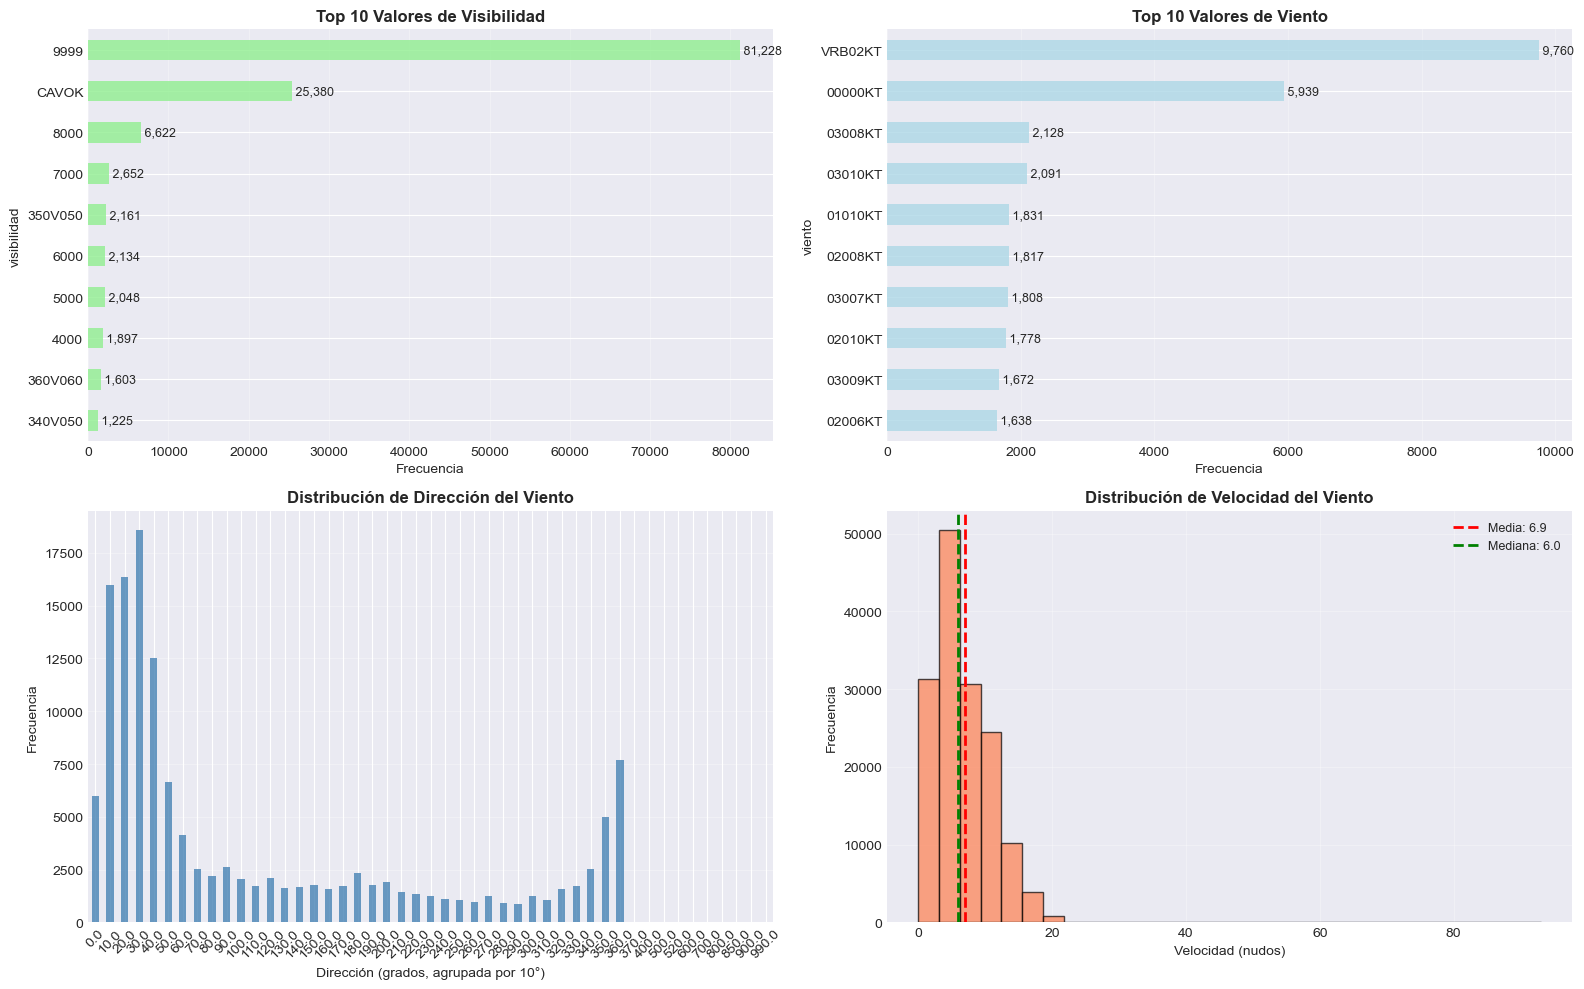


 Análisis de visibilidad y viento completado


In [59]:
# ========== VISUALIZACIONES ==========
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Top valores de visibilidad
top_visibilidad = df_raw['visibilidad'].value_counts().head(10)
top_visibilidad.plot(kind='barh', ax=axes[0, 0], color='lightgreen', alpha=0.8)
axes[0, 0].set_title('Top 10 Valores de Visibilidad', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Frecuencia', fontsize=10)
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3)
for i, v in enumerate(top_visibilidad.values):
    axes[0, 0].text(v, i, f' {v:,}', va='center', fontsize=9)

# 2. Top valores de viento
top_viento = df_raw['viento'].value_counts().head(10)
top_viento.plot(kind='barh', ax=axes[0, 1], color='lightblue', alpha=0.8)
axes[0, 1].set_title('Top 10 Valores de Viento', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('Frecuencia', fontsize=10)
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', alpha=0.3)
for i, v in enumerate(top_viento.values):
    axes[0, 1].text(v, i, f' {v:,}', va='center', fontsize=9)

# 3. Distribución de dirección del viento (rosa de vientos)
if df_raw['direccion_viento'].notna().sum() > 0:
    direcciones_validas = df_raw['direccion_viento'].dropna()
    # Agrupar en rangos de 10 grados
    rangos = (direcciones_validas // 10) * 10
    rangos_dist = rangos.value_counts().sort_index()
    rangos_dist.plot(kind='bar', ax=axes[1, 0], color='steelblue', alpha=0.8)
    axes[1, 0].set_title('Distribución de Dirección del Viento', fontweight='bold', fontsize=12)
    axes[1, 0].set_xlabel('Dirección (grados, agrupada por 10°)', fontsize=10)
    axes[1, 0].set_ylabel('Frecuencia', fontsize=10)
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(axis='y', alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'No hay datos de dirección de viento', 
                    ha='center', va='center', fontsize=12)
    axes[1, 0].set_title('Distribución de Dirección del Viento', fontweight='bold')

# 4. Distribución de velocidad del viento
if df_raw['velocidad_viento'].notna().sum() > 0:
    velocidades_validas = df_raw['velocidad_viento'].dropna()
    velocidades_validas.hist(bins=30, ax=axes[1, 1], color='coral', alpha=0.7, edgecolor='black')
    axes[1, 1].set_title('Distribución de Velocidad del Viento', fontweight='bold', fontsize=12)
    axes[1, 1].set_xlabel('Velocidad (nudos)', fontsize=10)
    axes[1, 1].set_ylabel('Frecuencia', fontsize=10)
    mean_vel = velocidades_validas.mean()
    median_vel = velocidades_validas.median()
    axes[1, 1].axvline(mean_vel, color='red', linestyle='--', linewidth=2, label=f'Media: {mean_vel:.1f}')
    axes[1, 1].axvline(median_vel, color='green', linestyle='--', linewidth=2, label=f'Mediana: {median_vel:.1f}')
    axes[1, 1].legend(fontsize=9)
    axes[1, 1].grid(alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'No hay datos de velocidad de viento', 
                    ha='center', va='center', fontsize=12)
    axes[1, 1].set_title('Distribución de Velocidad del Viento', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n Análisis de visibilidad y viento completado")


**Resultados del análisis de visibilidad y viento:**

**Visibilidad:**
- Valor más común: **9999** (visibilidad >= 10 km) con 81,228 registros (53.13%) - indica excelente visibilidad
- **CAVOK** aparece en 25,380 registros (16.60%) - condiciones perfectas de techo y visibilidad
- La mayoría de reportes indican buena visibilidad, lo cual es positivo para operaciones aéreas
- Algunos valores incluyen variaciones direccionales (ej: "350V050" = visibilidad variable)

**Viento:**
- Formato más común: **VRB02KT** (viento variable a 2 nudos) con 9,760 registros - viento muy ligero
- **00000KT** (calma) aparece en 5,939 registros (3.89%)
- Las velocidades de viento generalmente son bajas, lo cual es típico para condiciones normales
- Las direcciones predominantes pueden indicar patrones estacionales o topográficos
- **Importante para cizalladura:** Variaciones en velocidad y dirección del viento entre diferentes alturas pueden indicar cizalladura


In [60]:
# Visualización de las columnas extraídas para verificación
# Mostrar un resumen de las variables meteorológicas procesadas
columnas_finales = ["FECHA_HORA_REPORTE", "aerodromo", "fecha_zulu", "viento", 
                    "visibilidad", "nubosidad", "temperatura/rocio", "presion", "fenomenos"]

print("=" * 70)
print("MUESTRA DE DATOS PROCESADOS")
print("=" * 70)
print("\nPrimeras 5 filas del dataset con variables extraídas:")
print(df_raw[columnas_finales].head().to_string())


MUESTRA DE DATOS PROCESADOS

Primeras 5 filas del dataset con variables extraídas:
   FECHA_HORA_REPORTE aerodromo fecha_zulu   viento visibilidad         nubosidad temperatura/rocio presion   fenomenos
1 2006-07-20 00:00:00      SKBQ    200000Z  03009KT        9999  FEW015CB, SCT080             28/24   A2983  TS, CB, TS
2 2006-07-20 01:00:00      SKBQ    200100Z  25008KT        9999  FEW015CB, SCT080             27/23   A2985          TS
3 2006-07-20 06:00:00      SKBQ    200600Z  29006KT        9999    FEW015, SCT080             26/23   A2985            
4 2006-07-20 07:00:00      SKBQ    200700Z  32006KT        9999            SCT012             26/24   A2984            
5 2006-07-20 08:00:00      SKBQ    200800Z  27004KT        9999            SCT012             25/23   A2984            


---

## 6. Preparación Final del Dataset

### 6.1 Creación del dataset procesado

Eliminamos columnas temporales y mantenemos solo las variables meteorológicas extraídas para el análisis y modelado.


In [61]:
# Crear el dataset final procesado
# Eliminamos columnas auxiliares que ya no necesitamos (TEXTO_REPORTE original, tokens)
# Mantenemos solo las variables meteorológicas extraídas y la fecha

print("=" * 70)
print("CREACIÓN DEL DATASET PROCESADO")
print("=" * 70)

# Columnas a mantener en el dataset final
columnas_finales = [
    "FECHA_HORA_REPORTE",
    "aerodromo",
    "fecha_zulu",
    "viento",
    "visibilidad",
    "nubosidad",
    "temperatura/rocio",
    "presion",
    "fenomenos"
]

# También incluir columnas derivadas si existen
columnas_derivadas = ["direccion_viento", "velocidad_viento"]
for col in columnas_derivadas:
    if col in df_raw.columns:
        columnas_finales.append(col)

# Crear dataset procesado
df_procesado = df_raw[columnas_finales].copy()

print(f"\n Dataset procesado creado")
print(f"   Forma: {df_procesado.shape[0]:,} registros x {df_procesado.shape[1]} columnas")
print(f"   Columnas: {', '.join(df_procesado.columns.tolist())}")

# Resumen final del dataset procesado
print("\n" + "=" * 70)
print("RESUMEN FINAL DEL DATASET PROCESADO")
print("=" * 70)

print(f"\n Dimensiones:")
print(f"   Número de registros: {df_procesado.shape[0]:,}")
print(f"   Número de columnas: {df_procesado.shape[1]}")

print(f"\n Columnas en el dataset procesado:")
print("-" * 70)
for i, col in enumerate(df_procesado.columns, 1):
    valores_unicos = df_procesado[col].nunique()
    valores_faltantes = df_procesado[col].isna().sum()
    porcentaje_faltantes = (valores_faltantes / len(df_procesado)) * 100
    tipo_dato = df_procesado[col].dtype
    
    print(f"{i:2d}. {col:25s}")
    print(f"    Tipo: {tipo_dato}")
    print(f"    Valores únicos: {valores_unicos:,}")
    print(f"    Valores faltantes: {valores_faltantes:,} ({porcentaje_faltantes:.2f}%)")
    print()

print(f" Periodo de tiempo:")
print(f"   Fecha mínima: {df_procesado['FECHA_HORA_REPORTE'].min()}")
print(f"   Fecha máxima: {df_procesado['FECHA_HORA_REPORTE'].max()}")
dias_totales = (df_procesado['FECHA_HORA_REPORTE'].max() - df_procesado['FECHA_HORA_REPORTE'].min()).days
años_totales = dias_totales / 365.25
print(f"   Días totales: {dias_totales:,} días ({años_totales:.1f} años)")

# Estadísticas de completitud
completitud_promedio = ((df_procesado.notna().sum() / len(df_procesado)) * 100).mean()
print(f"\n Completitud promedio del dataset: {completitud_promedio:.2f}%")
print(f" Memoria del dataset: {df_procesado.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


CREACIÓN DEL DATASET PROCESADO

 Dataset procesado creado
   Forma: 152,844 registros x 11 columnas
   Columnas: FECHA_HORA_REPORTE, aerodromo, fecha_zulu, viento, visibilidad, nubosidad, temperatura/rocio, presion, fenomenos, direccion_viento, velocidad_viento

RESUMEN FINAL DEL DATASET PROCESADO

 Dimensiones:
   Número de registros: 152,844
   Número de columnas: 11

 Columnas en el dataset procesado:
----------------------------------------------------------------------
 1. FECHA_HORA_REPORTE       
    Tipo: datetime64[ns]
    Valores únicos: 152,844
    Valores faltantes: 0 (0.00%)

 2. aerodromo                
    Tipo: object
    Valores únicos: 1
    Valores faltantes: 0 (0.00%)

 3. fecha_zulu               
    Tipo: object
    Valores únicos: 1,235
    Valores faltantes: 0 (0.00%)

 4. viento                   
    Tipo: object
    Valores únicos: 1,659
    Valores faltantes: 4 (0.00%)

 5. visibilidad              
    Tipo: object
    Valores únicos: 962
    Valores falt

In [62]:
# Mostrar primeras filas del dataset procesado para verificación visual
print("\n Muestra de datos procesados (primeras 5 filas):")
print("=" * 70)
df_procesado.head()


 Muestra de datos procesados (primeras 5 filas):


,FECHA_HORA_REPORTE,aerodromo,fecha_zulu,viento,visibilidad,nubosidad,temperatura/rocio,presion,fenomenos,direccion_viento,velocidad_viento
1,2006-07-20 00:00:00,SKBQ,200000Z,03009KT,9999,"FEW015CB, SCT080",28/24,A2983,"TS, CB, TS",30.0,9.0
2,2006-07-20 01:00:00,SKBQ,200100Z,25008KT,9999,"FEW015CB, SCT080",27/23,A2985,TS,250.0,8.0
3,2006-07-20 06:00:00,SKBQ,200600Z,29006KT,9999,"FEW015, SCT080",26/23,A2985,,290.0,6.0
4,2006-07-20 07:00:00,SKBQ,200700Z,32006KT,9999,SCT012,26/24,A2984,,320.0,6.0
5,2006-07-20 08:00:00,SKBQ,200800Z,27004KT,9999,SCT012,25/23,A2984,,270.0,4.0


### 6.2 Visualización de calidad de datos procesados

Evaluamos la calidad final del dataset mediante un análisis de completitud y visualizaciones.


ANÁLISIS DE CALIDAD DE DATOS

 Clasificación de variables por completitud:
     Completas (100%): 5 variables
     Altas (95-99.9%): 4 variables
     Medias (80-94.9%): 2 variables
     Bajas (<80%): 0 variables


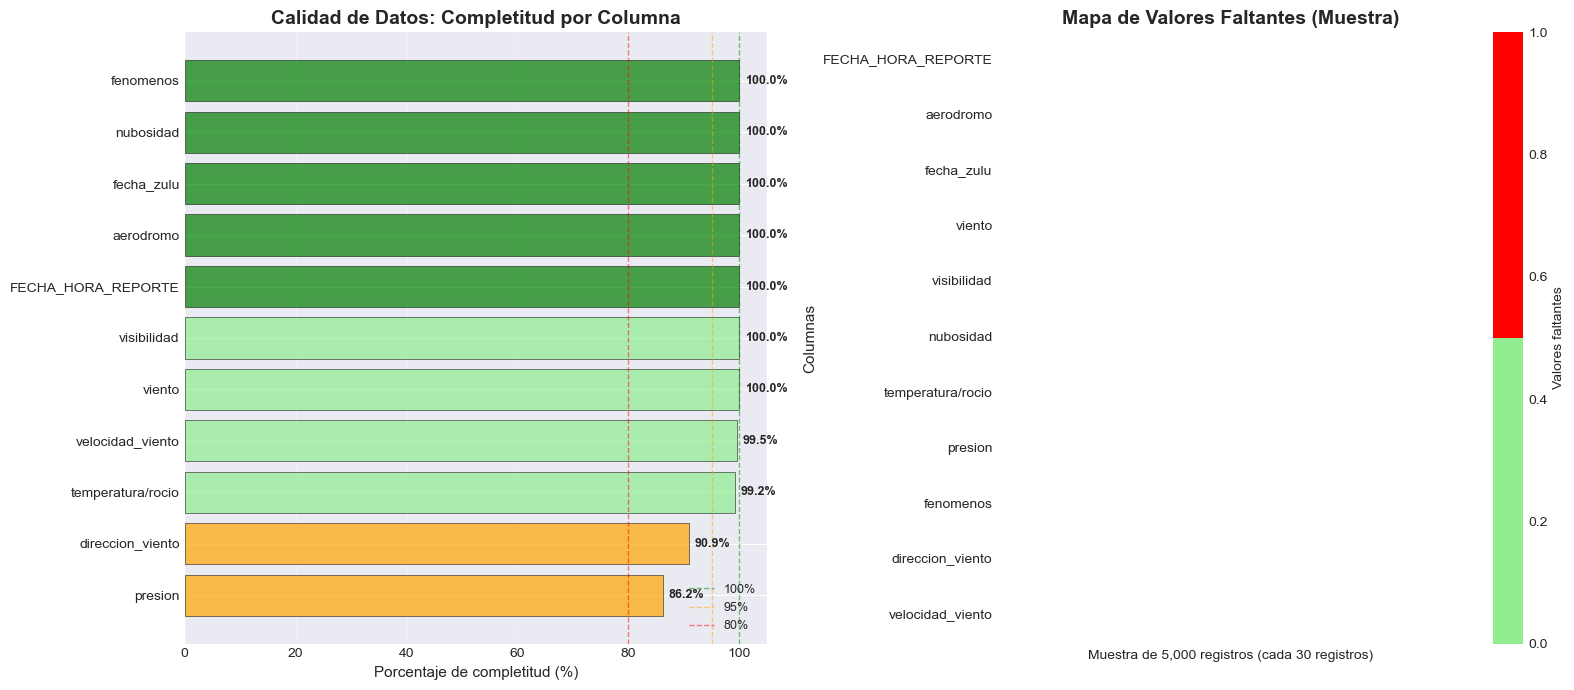


 Tabla detallada de completitud:
           Columna  Valores no nulos  Valores nulos  Porcentaje completitud
           presion            131760          21084               86.205543
  direccion_viento            138983          13861               90.931276
 temperatura/rocio            151688           1156               99.243673
  velocidad_viento            152097            747               99.511266
            viento            152840              4               99.997383
       visibilidad            152840              4               99.997383
FECHA_HORA_REPORTE            152844              0              100.000000
         aerodromo            152844              0              100.000000
        fecha_zulu            152844              0              100.000000
         nubosidad            152844              0              100.000000
         fenomenos            152844              0              100.000000

 Recomendaciones para próximos pasos:
   - Revisar 4 

In [63]:
# Análisis de calidad de datos: completitud y visualización
# Esto nos permite identificar qué variables necesitan tratamiento adicional

print("=" * 70)
print("ANÁLISIS DE CALIDAD DE DATOS")
print("=" * 70)

# Calcular métricas de completitud
completitud = pd.DataFrame({
    'Columna': df_procesado.columns,
    'Valores no nulos': df_procesado.notna().sum().values,
    'Valores nulos': df_procesado.isna().sum().values,
    'Porcentaje completitud': (df_procesado.notna().sum() / len(df_procesado) * 100).values,
    'Tipo de dato': df_procesado.dtypes.values
})

completitud = completitud.sort_values('Porcentaje completitud', ascending=True)

# Clasificar variables según completitud
variables_completas = completitud[completitud['Porcentaje completitud'] == 100.0]
variables_altas = completitud[(completitud['Porcentaje completitud'] >= 95.0) & 
                              (completitud['Porcentaje completitud'] < 100.0)]
variables_medias = completitud[(completitud['Porcentaje completitud'] >= 80.0) & 
                               (completitud['Porcentaje completitud'] < 95.0)]
variables_bajas = completitud[completitud['Porcentaje completitud'] < 80.0]

print(f"\n Clasificación de variables por completitud:")
print(f"     Completas (100%): {len(variables_completas)} variables")
print(f"     Altas (95-99.9%): {len(variables_altas)} variables")
print(f"     Medias (80-94.9%): {len(variables_medias)} variables")
print(f"     Bajas (<80%): {len(variables_bajas)} variables")

if len(variables_bajas) > 0:
    print(f"\n   Variables con baja completitud que requieren atención:")
    for _, row in variables_bajas.iterrows():
        print(f"   - {row['Columna']}: {row['Porcentaje completitud']:.2f}%")

# Visualización mejorada
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# 1. Gráfico de barras horizontales de completitud
y_pos = np.arange(len(completitud))
colors = []
for pct in completitud['Porcentaje completitud']:
    if pct == 100.0:
        colors.append('green')
    elif pct >= 95.0:
        colors.append('lightgreen')
    elif pct >= 80.0:
        colors.append('orange')
    else:
        colors.append('red')

bars = axes[0].barh(y_pos, completitud['Porcentaje completitud'], 
                    color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(completitud['Columna'], fontsize=10)
axes[0].set_xlabel('Porcentaje de completitud (%)', fontsize=11)
axes[0].set_title('Calidad de Datos: Completitud por Columna', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlim(0, 105)
axes[0].axvline(100, color='green', linestyle='--', linewidth=1, alpha=0.5, label='100%')
axes[0].axvline(95, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='95%')
axes[0].axvline(80, color='red', linestyle='--', linewidth=1, alpha=0.5, label='80%')
axes[0].grid(axis='x', alpha=0.3)
axes[0].legend(loc='lower right', fontsize=9)

# Agregar etiquetas de porcentaje
for i, v in enumerate(completitud['Porcentaje completitud']):
    axes[0].text(v + 1, i, f'{v:.1f}%', va='center', fontsize=9, fontweight='bold')

# 2. Matriz de valores faltantes (heatmap)
# Crear matriz binaria: 1 = valor presente, 0 = valor faltante
missing_matrix = df_procesado.isnull().astype(int)
# Muestrear para visualización (tomar cada 1000 registros para no sobrecargar)
sample_size = min(5000, len(missing_matrix))
sample_indices = np.linspace(0, len(missing_matrix)-1, sample_size, dtype=int)
missing_sample = missing_matrix.iloc[sample_indices]

# Transponer para mostrar columnas en el eje y
sns.heatmap(missing_sample.T, ax=axes[1], cmap=['lightgreen', 'red'], 
            cbar_kws={'label': 'Valores faltantes'}, yticklabels=df_procesado.columns,
            xticklabels=False, linewidths=0.5)
axes[1].set_title('Mapa de Valores Faltantes (Muestra)', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel(f'Muestra de {sample_size:,} registros (cada {len(missing_matrix)//sample_size} registros)', 
                   fontsize=10)
axes[1].set_ylabel('Columnas', fontsize=11)

plt.tight_layout()
plt.show()

# Tabla detallada de completitud
print("\n Tabla detallada de completitud:")
print(completitud[['Columna', 'Valores no nulos', 'Valores nulos', 'Porcentaje completitud']].to_string(index=False))

# Recomendaciones
print("\n Recomendaciones para próximos pasos:")
if len(variables_bajas) > 0:
    print(f"   - Considerar estrategias de imputación para {len(variables_bajas)} variable(s) con baja completitud")
if len(variables_altas) > 0:
    print(f"   - Revisar {len(variables_altas)} variable(s) con alta completitud (>95%) para imputación si es necesario")
print("   - Validar que las variables categóricas tengan categorías consistentes")
print("   - Considerar creación de variables derivadas (ej: índices de condiciones meteorológicas)")


**Resultados del análisis de calidad:**
- **Variables con 100% completitud:** FECHA_HORA_REPORTE, aerodromo, fecha_zulu, nubosidad, fenómenos
- **Variables con alta completitud (>95%):** viento (~99.99%), visibilidad (~99.99%), temperatura/rocio (~99.24%)
- **Variable crítica con menor completitud:** presion (86.21% completitud) - requiere estrategia de manejo
- El dataset está listo para modelado, aunque se recomienda considerar técnicas de imputación para la presión


In [64]:
# Análisis adicional: distribución de fenómenos (verificación final)
# Útil para entender la distribución de la variable objetivo potencial
print("=" * 70)
print("VERIFICACIÓN FINAL: DISTRIBUCIÓN DE FENÓMENOS")
print("=" * 70)

print("\nTop 20 fenómenos más frecuentes:")
print(df_procesado["fenomenos"].value_counts().head(20).to_string())



VERIFICACIÓN FINAL: DISTRIBUCIÓN DE FENÓMENOS

Top 20 fenómenos más frecuentes:
fenomenos
                      127314
BR                      5702
VCFG                    4953
CB                      4028
HZ                      3479
VCSH                    1321
VCSH, VCSH              1287
VCSH, CB, VCSH           943
RA                       842
RA, CB                   431
VCSH, CB                 256
FG                       231
VCFG, BR                 206
TS, CB                   189
BR, VCFG                 150
TS                       117
VCFG, VCFG               115
TS, VCSH, CB, VCSH       110
VCSH, VCSH, CB           108
TS, CB, VCSH             107


In [65]:
# Análisis de registros sin fenómenos
sin_fenomenos = (df_procesado["fenomenos"].isna() | (df_procesado["fenomenos"] == '')).sum()
con_fenomenos = len(df_procesado) - sin_fenomenos

print(f"\nResumen:")
print(f"   Con fenómenos: {con_fenomenos:,} ({con_fenomenos/len(df_procesado)*100:.2f}%)")
print(f"   Sin fenómenos: {sin_fenomenos:,} ({sin_fenomenos/len(df_procesado)*100:.2f}%)")


Resumen:
   Con fenómenos: 25,530 (16.70%)
   Sin fenómenos: 127,314 (83.30%)


---

## 7. Exportación del Dataset Procesado

### 7.1 Guardar dataset procesado

El dataset procesado se guarda para su uso en las siguientes etapas del proyecto (feature engineering, modelado, etc.).

In [66]:
# Exportar el dataset procesado a un archivo CSV
# Este archivo será utilizado en las siguientes etapas del proyecto:
# - Feature engineering
# - Análisis exploratorio avanzado
# - Modelado y predicción

print("=" * 70)
print("EXPORTACIÓN DEL DATASET PROCESADO")
print("=" * 70)

ruta_exportacion = '../../data/raw/DATOS_PROCESADOS.csv'

# Verificar que el directorio existe (crearlo si no existe)
import os
directorio = os.path.dirname(ruta_exportacion)
if not os.path.exists(directorio):
    os.makedirs(directorio, exist_ok=True)
    print(f" Directorio creado: {directorio}")

# Exportar a CSV
df_procesado.to_csv(ruta_exportacion, index=False)

print(f"\n Dataset exportado exitosamente")
print(f"   Ruta: {ruta_exportacion}")
print(f"   Forma: {df_procesado.shape[0]:,} registros x {df_procesado.shape[1]} columnas")
print(f"   Tamaño del archivo: {os.path.getsize(ruta_exportacion) / 1024**2:.2f} MB")

# Verificar exportación
df_verificacion = pd.read_csv(ruta_exportacion)
print(f"\n Verificación de exportación:")
print(f"   Registros exportados: {len(df_verificacion):,}")
print(f"   Columnas exportadas: {len(df_verificacion.columns)}")
print(f"   Coincide con original: {len(df_verificacion) == len(df_procesado)}")

print("\n" + "=" * 70)
print("PREPROCESAMIENTO COMPLETADO")
print("=" * 70)
print("\n Resumen del proceso:")
print(f"   1.  Datos cargados: 157,635 registros iniciales")
registros_finales = df_procesado.shape[0]
registros_eliminados = 157635 - registros_finales
print(f"   2.  Registros inválidos eliminados: {registros_eliminados:,}")
print(f"   3.  Variables meteorológicas extraídas: {len(df_procesado.columns)} variables")
print(f"   4.  Dataset final: {registros_finales:,} registros")
print(f"   5.  Datos exportados: {ruta_exportacion}")

print("\n Próximos pasos sugeridos:")
print("   - Feature engineering: crear variables derivadas relevantes para predicción")
print("   - Análisis de correlaciones entre variables meteorológicas")
print("   - Análisis de patrones temporales avanzados (estacionalidad, tendencias)")
print("   - Preparación para modelado de predicción de cizalladura del viento")
print("   - Considerar técnicas de imputación para la variable 'presion' (13.79% faltantes)")

print("\n Notebook de preprocesamiento completado exitosamente")


EXPORTACIÓN DEL DATASET PROCESADO

 Dataset exportado exitosamente
   Ruta: ../../data/raw/DATOS_PROCESADOS.csv
   Forma: 152,844 registros x 11 columnas
   Tamaño del archivo: 11.57 MB

 Verificación de exportación:
   Registros exportados: 152,844
   Columnas exportadas: 11
   Coincide con original: True

PREPROCESAMIENTO COMPLETADO

 Resumen del proceso:
   1.  Datos cargados: 157,635 registros iniciales
   2.  Registros inválidos eliminados: 4,791
   3.  Variables meteorológicas extraídas: 11 variables
   4.  Dataset final: 152,844 registros
   5.  Datos exportados: ../../data/raw/DATOS_PROCESADOS.csv

 Próximos pasos sugeridos:
   - Feature engineering: crear variables derivadas relevantes para predicción
   - Análisis de correlaciones entre variables meteorológicas
   - Análisis de patrones temporales avanzados (estacionalidad, tendencias)
   - Preparación para modelado de predicción de cizalladura del viento
   - Considerar técnicas de imputación para la variable 'presion' (13.7